Популяция состоит из трафиков.  
Трафик состоит из периодов.  
Периоды включают в себя троллейбусы.  
Троллейбусы говорят о кол-ве машин и людях.  

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
ROUTES = (7,10,11,12,16,24,25,29,32)
DAYS = 31
POPULATION_COUNT = 500
GENERATIONS = 150

In [3]:
class BKM321:
    seat_places = 26
    capacity = 115
    count = 101

In [4]:
class Trolleybus:
    def __init__(self,id,cars=1,people=1500,model=BKM321):
        self.id = id
        self.car = model()
        self.cars = cars
        self.people = people

In [5]:
class Traffic:
    def __init__(self,tbuses,days=5,model=BKM321, random=True):
        self.tbuses = []
        self.days = days
        
        for d in range(self.days):
            self.tbuses.append([])
            
            if random:
                for t in tbuses:
                    cars = np.random.randint(1,model.count/len(ROUTES)+1)
                    people = np.random.randint(1,cars*model.capacity+1)
                    self.tbuses[d].append(Trolleybus(id=t,cars=cars,people=people))
            
    def tolist(self):
        return [[[t.id,t.cars,t.people] for t in period] for period in self.tbuses]
    
    def toarray(self):
        return np.array(self.tolist())
    
    @staticmethod
    def create(nparray,days):
        traf_array = Traffic(ROUTES,days,random=False)
        for d in range(len(nparray)):
            for c in range(len(nparray[d])):
                t = Trolleybus(id=nparray[d][c][0],cars=nparray[d][c][1],people=nparray[d][c][2])
                traf_array.tbuses[d].append(t)
        return traf_array
    
    @staticmethod
    def to_traffics(arrays,days):
        for i in range(len(arrays)):
            arrays[i] = Traffic.create(arrays[i],days)
        return arrays
            
    def __str__(self):
        r = []
        for d in range(len(self.tbuses)):
            r.append(f"Day {d+1}: ")
            for t in self.tbuses[d]:
                r.append(f"{t.id} {t.cars} {t.people} | ")
            r.append("\n")
        return "".join(r)
    
    def __repr__(self):
        return self.__str__()

In [6]:
def generate_random_traffic(days, model = BKM321):
    traffic = Traffic(tbuses = ROUTES, days = days, model = model)
    return traffic

In [7]:
def population(n, days = 7):
    population = []
    for _ in range(n):
        population.append(generate_random_traffic(days))
    return population

In [8]:
def cost(traffic, traffic_goal):
    errors = traffic - traffic_goal
    cost = 0
    for i in errors:
        for j in i:
            cost += abs(j[1] * j[2])
    return cost

In [9]:
def get_population(generation):
    inds = dict()
    for i in range(len(generation)):
        for j in range(len(generation[i].tbuses)):
            for k in range(len(generation[i].tbuses[j])):
                t = get_tbus(generation,i,j,k)
                key = (i,j,k)
                value = (t.cars,t.people)
                inds[key] = value
    return inds
def sort_population(individuals):
    return sorted(individuals, key=lambda k: (individuals[k][0], individuals[k][1]))
def get_tbus(generation,i,j,k):
    return generation[i].tbuses[j][k]

In [10]:
def select_best(generation, goal):
    best = {}
    for g in range(len(generation)):
        best[g] = cost(generation[g].toarray(),goal)
    _best = sorted(best, key=lambda k: best[k])
    best = []
    for b in _best[:POPULATION_COUNT//2]:
        best.append(generation[b])
    return best

In [11]:
def crossover(parents, offspring_count):
    parents_count = len(parents)
    
    offsprings = []
    for i in range(offspring_count):
        for j in range(parents_count):
            parent1 = parents[np.random.randint(0, parents_count)].toarray()
            parent2 = parents[np.random.randint(0, parents_count)].toarray()

            parent1_mask = np.random.randint(0, 2, size = parent1.shape)
            parent2_mask = np.logical_not(parent1_mask)

            offspring = np.add(np.multiply(parent1, parent1_mask), np.multiply(parent2, parent2_mask))
            offspring = np.array(offspring)
            offsprings.append(Traffic.create(offspring,DAYS))
        
    return offsprings

In [12]:
def mutation(individual, mutations_count):
    size1 = individual.shape[0]
    size2 = individual.shape[1]
    for i in range(mutations_count):
        day = np.random.randint(0, size1)
        tbus = np.random.randint(0, size2)
        
        #Cars
        d = np.random.choice((-1,1))
        individual[day,tbus,1] += d
        
        #People
        d = np.random.choice(np.arange(-5,6))
        individual[day,tbus,2] += d
        
    return individual

In [13]:
def mutate(offspring):
    for i in range(0,len(offspring),2):
        offspring[i] = mutation(offspring[i].toarray(), 2)
        offspring[i] = Traffic.create(offspring[i],DAYS)
    return offspring

In [14]:
def set_goal(days, goal_cars = 1, goal_people = 1500):
    return np.array([[[r,goal_cars,goal_people] for r in ROUTES] for _ in range(days)])

In [15]:
def genetic_algorithm(generation, goal):
    best = select_best(generation, goal)    
    offsprings = crossover(best, 2)
    mutants = mutate(offsprings)
    return mutants

In [16]:
goal = set_goal(days=DAYS,goal_cars=1,goal_people=1500)
generation = population(POPULATION_COUNT,DAYS)
_generation = generation
_fcost = 0
acc_list = []

for g in range(GENERATIONS):
    generation = genetic_algorithm(generation,goal)
    
    #Accuracy
    _cost = cost(select_best(generation,goal)[0].toarray(),goal)
    if _fcost == 0:
        _fcost = _cost
    acc = abs(round((1 - _cost / _fcost)*100,2))
    acc_list.append(acc)
    
    print(f"Generation's {g} cost: {_cost}, acc: {acc}%")

Generation's 0 cost: 1321072, acc: 0.0%
Generation's 1 cost: 1286840, acc: 2.59%
Generation's 2 cost: 1322588, acc: 0.11%
Generation's 3 cost: 1238960, acc: 6.22%
Generation's 4 cost: 1207457, acc: 8.6%
Generation's 5 cost: 1173072, acc: 11.2%
Generation's 6 cost: 1141408, acc: 13.6%
Generation's 7 cost: 1158264, acc: 12.32%
Generation's 8 cost: 1096412, acc: 17.01%
Generation's 9 cost: 1016413, acc: 23.06%
Generation's 10 cost: 1041272, acc: 21.18%
Generation's 11 cost: 991927, acc: 24.91%
Generation's 12 cost: 942254, acc: 28.68%
Generation's 13 cost: 928978, acc: 29.68%
Generation's 14 cost: 923495, acc: 30.1%
Generation's 15 cost: 880786, acc: 33.33%
Generation's 16 cost: 846349, acc: 35.93%
Generation's 17 cost: 789115, acc: 40.27%
Generation's 18 cost: 770021, acc: 41.71%
Generation's 19 cost: 765012, acc: 42.09%
Generation's 20 cost: 699194, acc: 47.07%
Generation's 21 cost: 674180, acc: 48.97%
Generation's 22 cost: 649653, acc: 50.82%
Generation's 23 cost: 645884, acc: 51.11%
G

KeyboardInterrupt: 

In [17]:
THE_BEST = select_best(generation,goal)
pd.DataFrame(THE_BEST[0].toarray().reshape(-1,3)[:DAYS], columns=("ID","Cars","People"))

,ID,Cars,People
0,7,1,215
1,10,1,339
2,11,1,264
3,12,1,279
4,16,1,611
5,24,1,315
6,25,1,146
7,29,1,1114
8,32,1,463
9,7,1,938


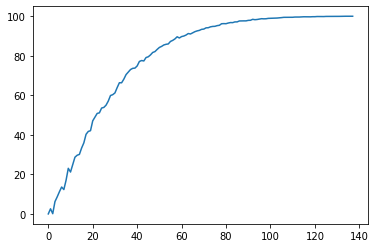

In [19]:
plt.plot(acc_list)